In [3]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import utils
import algo
import os
import itertools
import pickle
from tqdm import tqdm
from scipy.stats import binomtest, binom
%matplotlib widget

In [4]:
def get_features(feats_path_folder, video_id, len_seg, offset=None, smooth=True):
    with open(feats_path_folder + video_id + '_mask.pkl', 'rb') as f:
        feats = pickle.load(f)
    feats = np.concatenate(tuple(feats), axis=0)
    feats = utils.clean_features(feats, smooth=smooth)
    if offset is not None:
        end_idx = min(offset + len_seg, feats.shape[0])
        start_idx = end_idx - len_seg
        feats = feats[start_idx:end_idx, :]
    else:
        feats = feats[:len_seg, :]
    return feats

In [5]:
def get_gaze(gaze_path, len_seg, offset=None):
    gaze = np.load(gaze_path, allow_pickle=True)
    # interpolate missing values
    gaze = np.array([np.nan if x is None else x for x in gaze])
    gaze_clean = utils.clean_features(gaze.astype(np.float64), smooth=False)
    if offset is not None:
        end_idx = min(offset + len_seg, gaze_clean.shape[0])
        start_idx = end_idx - len_seg
        gaze_clean = gaze_clean[start_idx:end_idx, :]
    else:
        gaze_clean = gaze_clean[:len_seg, :]
    return gaze_clean

In [6]:
def get_eeg_eog(eeg_path, fsStim, bads, expdim=True):
    eeg_prepro, fs, _ = utils.preprocessing(eeg_path, HP_cutoff = 0.5, AC_freqs=50, band=None, resamp_freqs=fsStim, bads=bads, eog=True, regression=True, normalize=True)
    eeg_channel_indices = mne.pick_types(eeg_prepro.info, eeg=True)
    eog_channel_indices = mne.pick_types(eeg_prepro.info, eog=True)
    eeg_downsampled, _ = eeg_prepro[eeg_channel_indices]
    eog_downsampled, _ = eeg_prepro[eog_channel_indices]
    if expdim:
        eeg_downsampled = np.expand_dims(eeg_downsampled.T, axis=2)
        eog_downsampled = np.expand_dims(eog_downsampled.T, axis=2)
    return eeg_downsampled, eog_downsampled, fs

In [7]:
def data_per_subj(eeg_folder, fsStim, bads, singleobj, feats_path_folder=None, expdim=True):
    eeg_files_all = [file for file in os.listdir(eeg_folder) if file.endswith('.set')]
    if singleobj:
        files = [file for file in eeg_files_all if len(file.split('_')) == 1]
    else:
        files = [file for file in eeg_files_all if len(file.split('_')) == 3]
    files.sort()
    nb_files = len(files)
    eeg_list = []
    eog_list = []
    len_seg_list = []
    gaze_list = []
    for file in files:
        eeg_downsampled, eog_downsampled, fs = get_eeg_eog(eeg_folder + file, fsStim, bads, expdim)
        eeg_list.append(eeg_downsampled)
        eog_list.append(eog_downsampled)
        len_seg_list.append(eeg_downsampled.shape[0])
        id_att = file[:-4].split('_')[-1]
        gaze_file = [file for file in os.listdir(eeg_folder) if file.endswith('.npy') and file.split('_')[-2]==id_att]
        if len(gaze_file) == 1:
            offset = 122 * fsStim if not singleobj else None
            gaze = get_gaze(eeg_folder + gaze_file[0], len_seg_list[-1], offset)
            gaze = np.expand_dims(gaze, axis=2)
        else:
            gaze = np.zeros((len_seg_list[-1], 2, 1))
        gaze_list.append(gaze)
    if feats_path_folder is not None:
        feat_att_list = []
        feat_unatt_list = []
        for i in range(len(files)):
            file = files[i]
            len_seg = len_seg_list[i]
            name = file[:-4]
            id_att = name.split('_')[-1]
            if singleobj:
                feats_att = get_features(feats_path_folder, id_att, len_seg, offset=None, smooth=True)
                feats_unatt = None
            else:
                offset = 122 * fsStim
                ids = set(name.split('_'))
                ids.remove(id_att)
                id_unatt = ids.pop()
                feats_att = get_features(feats_path_folder, id_att, len_seg, offset, smooth=True)
                feats_unatt = get_features(feats_path_folder, id_unatt, len_seg, offset, smooth=True)
            feat_att_list.append(feats_att)
            feat_unatt_list.append(feats_unatt)
    else:
        feat_att_list = None
        feat_unatt_list = None
    return eeg_list, eog_list, feat_att_list, feat_unatt_list, gaze_list, fs, nb_files, len_seg_list

In [8]:
def data_multi_subj(subj_path, fsStim, bads, singleobj, feats_path_folder, SAVE=True):
    PATTERN = subj_path[0].split('/')[-3]
    data_path = 'data/' + PATTERN + '/'
    if not os.path.exists(data_path):
        os.makedirs(data_path)
    nb_subj = len(subj_path)
    eeg_multisubj_list, eog_multisubj_list, feat_att_list, feat_unatt_list, gaze_multisubj_list, fs, nb_files, len_seg_list = data_per_subj(subj_path[0], fsStim, bads[0], singleobj, feats_path_folder)
    for n in range(1,nb_subj):
        eeg_list, eog_list, _, _, gaze_list, _, nb_files_sub, _ = data_per_subj(subj_path[n], fsStim, bads[n], singleobj, feats_path_folder=None)
        assert nb_files == nb_files_sub
        eeg_multisubj_list = [np.concatenate((eeg_multisubj_list[i], eeg_list[i]), axis=2) for i in range(nb_files)]
        eog_multisubj_list = [np.concatenate((eog_multisubj_list[i], eog_list[i]), axis=2) for i in range(nb_files)]
        gaze_multisubj_list = [np.concatenate((gaze_multisubj_list[i], gaze_list[i]), axis=2) for i in range(nb_files)]
    if SAVE:
        # save all data (eeg_multisubj_list, eog_multisubj_list, feat_att_list, feat_unatt_list, fs, nb_files) into a single file
        data = {'eeg_multisubj_list': eeg_multisubj_list, 'eog_multisubj_list': eog_multisubj_list, 'feat_att_list': feat_att_list, 'feat_unatt_list': feat_unatt_list, 'gaze_multisubj_list': gaze_multisubj_list, 'fs': fs, 'len_seg_list': len_seg_list}
        file_name = 'data_singleobj.pkl' if singleobj else 'data_twoobj.pkl'
        with open(data_path + file_name, 'wb') as f:
            pickle.dump(data, f)
    return eeg_multisubj_list, eog_multisubj_list, feat_att_list, feat_unatt_list, gaze_multisubj_list, fs, len_seg_list

In [9]:
def add_new_data(subj_path, fsStim, bads, feats_path_folder, singleobj):
    PATTERN = subj_path[0].split('/')[-3]
    data_path = 'data/' + PATTERN + '/'
    file_name = 'data_singleobj.pkl' if singleobj else 'data_twoobj.pkl'
    with open(data_path + file_name, 'rb') as f:
        data = pickle.load(f)
    nb_subj_old = data['eeg_multisubj_list'][0].shape[2]
    eeg_multisubj_add, eog_multisubj_add, _, _, gaze_multisubj_add, _, _ = data_multi_subj(subj_path[nb_subj_old:], fsStim, bads[nb_subj_old:], singleobj, feats_path_folder, SAVE=False)
    eeg_multisubj_list = [np.concatenate((old, new), axis=2) for old, new in zip(data['eeg_multisubj_list'], eeg_multisubj_add)]
    eog_multisubj_list = [np.concatenate((old, new), axis=2) for old, new in zip(data['eog_multisubj_list'], eog_multisubj_add)]
    gaze_multisubj_list = [np.concatenate((old, new), axis=2) for old, new in zip(data['gaze_multisubj_list'], gaze_multisubj_add)]
    data['eeg_multisubj_list'] = eeg_multisubj_list
    data['eog_multisubj_list'] = eog_multisubj_list
    data['gaze_multisubj_list'] = gaze_multisubj_list
    with open(data_path + file_name, 'wb') as f:
        pickle.dump(data, f)
    return eeg_multisubj_list, eog_multisubj_list, data['feat_att_list'], data['feat_unatt_list'], gaze_multisubj_list, data['fs'], data['len_seg_list']

In [10]:
def remove_shot_cuts(data, fs, time_points=None, remove_time=1):
    T = data.shape[0]
    if time_points is None:
        time_points = [0, T]
    nearby_idx = []
    for p in time_points:
        len_points = int(remove_time*fs)
        nearby_idx = nearby_idx + list(range(max(0, p-len_points), min(p+len_points, T)))
    nearby_idx = list(set(nearby_idx))
    data_clean = np.delete(data, nearby_idx, axis=0)
    return data_clean

In [11]:
def load_data(subj_path, fsStim, bads, feats_path_folder, PATTERN, singleobj, LOAD_ONLY, ALL_NEW):
    file_name = 'data_singleobj.pkl' if singleobj else 'data_twoobj.pkl'
    if LOAD_ONLY:
        data_path = 'data/' + PATTERN + '/'
        with open(data_path + file_name, 'rb') as f:
            data = pickle.load(f)
        eeg_multisubj_list = data['eeg_multisubj_list']
        eog_multisubj_list = data['eog_multisubj_list']
        feat_att_list = data['feat_att_list']
        feat_unatt_list = data['feat_unatt_list']
        gaze_multisubj_list = data['gaze_multisubj_list']
        fs = data['fs']
        len_seg_list = data['len_seg_list']
    else:
        if ALL_NEW:
            eeg_multisubj_list, eog_multisubj_list, feat_att_list, feat_unatt_list, gaze_multisubj_list, fs, len_seg_list = data_multi_subj(subj_path, fsStim, bads, singleobj, feats_path_folder)
        else:
            eeg_multisubj_list, eog_multisubj_list, feat_att_list, feat_unatt_list, gaze_multisubj_list, fs, len_seg_list = add_new_data(subj_path, fsStim, bads, feats_path_folder, singleobj)
    return eeg_multisubj_list, eog_multisubj_list, feat_att_list, feat_unatt_list, gaze_multisubj_list, fs, len_seg_list

In [12]:
# Check the alignment between eog and gaze. The synchronization is good if the peaks of two signals (eye blinks) are aligned.
def check_alignment(subj_ID, eog_multisubj_list, gaze_multisubj_list, nb_points=500):
    eog_one_subj_list = [eog[:,:,subj_ID] for eog in eog_multisubj_list]
    gaze_one_subj_list = [gaze[:,:,subj_ID] for gaze in gaze_multisubj_list]
    eog_verti_list = [eog[:,0] - eog[:,1] for eog in eog_one_subj_list]
    gaze_y_list = [gaze[:,1] for gaze in gaze_one_subj_list]
    nb_videos = len(eog_verti_list)
    # make a subplot (3 x (nb_videos//3+1)) for each video
    plt.close()
    nb_rows = 3
    nb_cols = nb_videos//3+1
    fig, ax = plt.subplots(nb_rows, nb_cols, figsize=(15, 10))
    for i in range(nb_videos):
        ax[i//nb_cols, i%nb_cols].plot(eog_verti_list[i][-nb_points:]/np.max(eog_verti_list[i][-nb_points:]), label='eog vertical')
        ax[i//nb_cols, i%nb_cols].plot(gaze_y_list[i][-nb_points:]/np.max(gaze_y_list[i][-nb_points:]), label='gaze y')
        ax[i//nb_cols, i%nb_cols].set_title('Video ' + str(i+1))
        ax[i//nb_cols, i%nb_cols].legend()
    plt.show()

### Load data

In [43]:
subjects = ['Pilot_1', 'Pilot_2', 'Pilot_4']
PATTERN = 'Overlay'
subj_path = ['../../Experiments/data/Two_Obj/' + PATTERN + '/' + sub + '/' for sub in subjects]
nb_subj = len(subjects)
bads = [['A30', 'B25'], ['B25'], ['B25']] 
fsStim = 30
feats_path_folder = '../Feat_Multi/features/'

In [44]:
%%capture
singleobj = False
eeg_multisubj_list, eog_multisubj_list, feat_all_att_list, feat_all_unatt_list, gaze_multisubj_list, fs, len_seg_list = load_data(subj_path, fsStim, bads, feats_path_folder, PATTERN, singleobj, LOAD_ONLY=True, ALL_NEW=False)

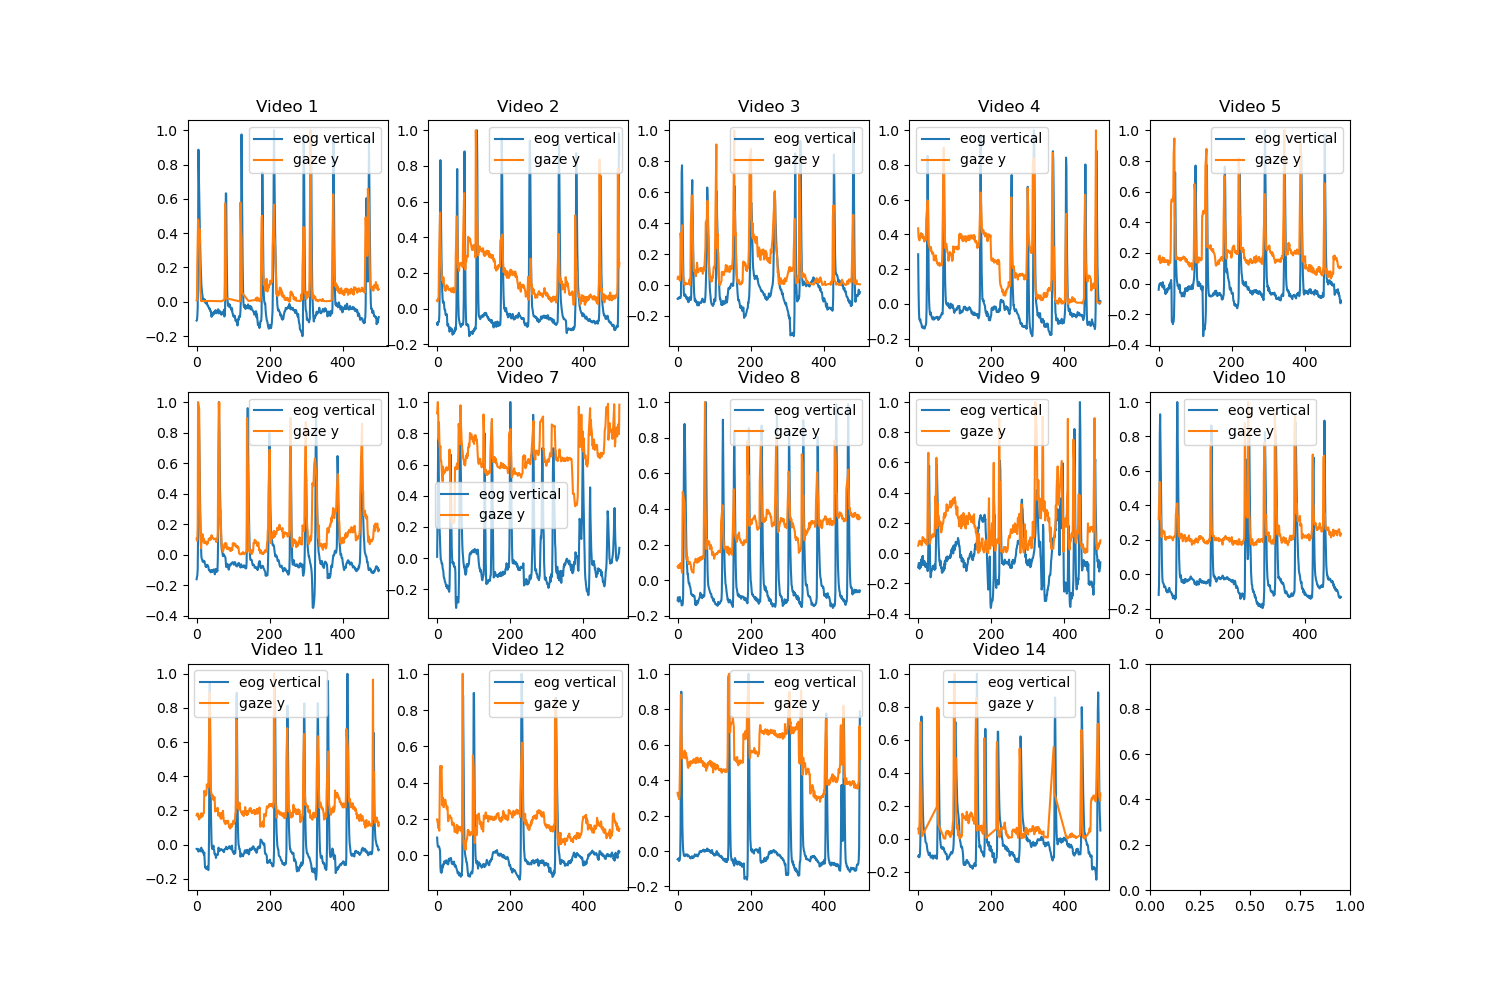

In [74]:
# Check the alignment between eog and gaze. The synchronization is good if the peaks of two signals (eye blinks) are aligned.
subj_to_check = 0
eog_one_subj_list = [eog[:,:,subj_to_check] for eog in eog_multisubj_list]
gaze_one_subj_list = [gaze[:,:,subj_to_check] for gaze in gaze_multisubj_list]
eog_verti_list = [eog[:,0] - eog[:,1] for eog in eog_one_subj_list]
gaze_y_list = [gaze[:,1] for gaze in gaze_one_subj_list]
nb_videos = len(eog_verti_list)
# make a subplot (3 x (nb_videos//3+1)) for each video
plt.close()
nb_rows = 3
nb_cols = nb_videos//3+1
nb_points = 500
fig, ax = plt.subplots(nb_rows, nb_cols, figsize=(15, 10))
for i in range(nb_videos):
    ax[i//nb_cols, i%nb_cols].plot(eog_verti_list[i][-nb_points:]/np.max(eog_verti_list[i][-nb_points:]), label='eog vertical')
    ax[i//nb_cols, i%nb_cols].plot(gaze_y_list[i][-nb_points:]/np.max(gaze_y_list[i][-nb_points:]), label='gaze y')
    ax[i//nb_cols, i%nb_cols].set_title('Video ' + str(i+1))
    ax[i//nb_cols, i%nb_cols].legend()
plt.show()


In [45]:
RemoveSC = True
if RemoveSC:
    eeg_multisubj_list = [remove_shot_cuts(eeg, fs) for eeg in eeg_multisubj_list]
    eog_multisubj_list = [remove_shot_cuts(eog, fs) for eog in eog_multisubj_list]
    gaze_multisubj_list = [remove_shot_cuts(gaze, fs) for gaze in gaze_multisubj_list]
    feat_all_att_list = [remove_shot_cuts(feat, fs) for feat in feat_all_att_list]
    if not singleobj:
        feat_all_unatt_list = [remove_shot_cuts(feat, fs) for feat in feat_all_unatt_list]

In [13]:
# eeg_band_list = [utils.extract_freq_band(eeg, fsStim, band=[0.1,5]) for eeg in eeg_multisubj_list]

In [46]:
objflow_att_list = [feats[:,8] for feats in feat_all_att_list]
objtempctr_att_list = [feats[:,17] for feats in feat_all_att_list]
if not singleobj:
    objflow_unatt_list = [feats[:,8] for feats in feat_all_unatt_list]
    objtempctr_unatt_list = [feats[:,17] for feats in feat_all_unatt_list]

In [47]:
objflow_att = np.concatenate(objflow_att_list, axis=0)
objtempctr_att = np.concatenate(objtempctr_att_list, axis=0)
if not singleobj:
    objflow_unatt = np.concatenate(objflow_unatt_list, axis=0)
    objtempctr_unatt = np.concatenate(objtempctr_unatt_list, axis=0)
    # calculate the correlation between objflow_att and objflow_unatt
    print(np.corrcoef(objflow_att, objflow_unatt)[0,1])
    # calculate the correlation between objtempctr_att and objtempctr_unatt
    print(np.corrcoef(objtempctr_att, objtempctr_unatt)[0,1])

In [48]:
L_EEG = 3 
L_Stim = int(fsStim/2) 
offset_EEG = 1 
offset_Stim = 0 
trial_len_list = list(range(5, 125, 5))

In [49]:
figure_path = 'figures/' + PATTERN + '/'
if not os.path.exists(figure_path):
    os.makedirs(figure_path)
table_path = 'tables/' + PATTERN + '/'
if not os.path.exists(table_path):
    os.makedirs(table_path)

### Train and test using attended features vs unattended features

In [50]:
def pipe_CCA_mm(Subj_ID, eeg_multisubj_list, feat_list, fs, L_EEG, L_Stim, offset_EEG, offset_Stim, figure_name, table_name, fold=5, n_components=5, ifEOG=False, trials=True, trial_len_list=None):
    eeg_onesubj_list = [eeg[:,:,Subj_ID] for eeg in eeg_multisubj_list]
    CCA = algo.CanonicalCorrelationAnalysis(eeg_onesubj_list, feat_list, fs, L_EEG, L_Stim, offset_EEG, offset_Stim, fold=fold, n_components=n_components, trials=trials)
    _, corr_test, sig_corr, _, _, _, _, V_A_train, _ = CCA.cross_val()
    # find the indices of np.average(corr_test, axis=0) > sig_corr
    idx_sig = np.where(np.average(corr_test, axis=0) > sig_corr)[0]
    if not ifEOG:
        eeg_onesub = np.concatenate(tuple(eeg_onesubj_list), axis=0)
        forward_model = CCA.forward_model(eeg_onesub, V_A_train)
        utils.plot_spatial_resp(forward_model, corr_test, figure_name, idx_sig=idx_sig)
    if trial_len_list is not None:
        acc_mm = []
        for trial_len in trial_len_list:
            corr_tensor_list, _ = CCA.match_mismatch(trial_len)
            match_stim_err, _ = utils.eval_mm(corr_tensor_list, component=1)
            acc_mm.append(1-match_stim_err)
        # save the results
        results = {'acc': acc_mm, 'trial_len_list': trial_len_list}
        with open(table_name, 'wb') as f:
            pickle.dump(results, f)

In [51]:
Subj_ID = 2 # starts from 0
feat_list = objflow_att_list
figure_name = figure_path + str(Subj_ID+1) + '_att.png'
table_name = table_path + str(Subj_ID+1) + '_mm_att.pkl'
pipe_CCA_mm(Subj_ID, eeg_multisubj_list, feat_list, fsStim, L_EEG, L_Stim, offset_EEG, offset_Stim, figure_name, table_name, trials=True, trial_len_list=None)

100%|██████████| 1000/1000 [00:02<00:00, 400.00it/s]


Significance level: 0.019966849394927235
Average correlation coefficients of the top 5 components on the training sets: [0.12241668 0.11127044 0.07619735 0.06966933 0.06486111]
Average correlation coefficients of the top 5 components on the test sets: [0.03077845 0.02754333 0.00978279 0.00243282 0.00581846]


In [ ]:
Subj_ID = 2
feat_list = objflow_unatt_list
figure_name = figure_path + str(Subj_ID+1) + '_unatt.png'
table_name = table_path + str(Subj_ID+1) + '_mm_unatt.pkl'
pipe_CCA_mm(Subj_ID, eeg_multisubj_list, feat_list, fsStim, L_EEG, L_Stim, offset_EEG, offset_Stim, figure_name, table_name, trials=True, trial_len_list=None)

In [52]:
# # Similar, but train with attended features
# def unatt_match_mismatch(eeg_list, feat_att_list, feat_unatt_list, fsStim, L_EEG, L_Stim, offset_EEG, offset_Stim, fold=5, n_components=3, trial_len=30, rerank=True):
#     corr_tensor_list = []
#     tsc_mtx_list = []
#     CCA = algo.CanonicalCorrelationAnalysis(eeg_list, feat_att_list, fsStim, L_EEG, L_Stim, offset_EEG, offset_Stim, n_components=n_components, fold=fold)
#     for idx in range(fold):
#         EEG_train, EEG_test, Att_train, _ = utils.split_balance(eeg_list, feat_att_list, fold=fold, fold_idx=idx+1)
#         _, _, _, Unatt_test = utils.split_balance(eeg_list, feat_unatt_list, fold=fold, fold_idx=idx+1)
#         _, _, _, _, V_eeg_train, V_feat_train, _ = CCA.fit(EEG_train, Att_train)
#         EEG_trials = utils.into_trials(EEG_test, fsStim, trial_len)
#         Unatt_trials = utils.into_trials(Unatt_test, fsStim, trial_len)
#         nb_trials = len(Unatt_trials)
#         corr_tensor = np.zeros((nb_trials, nb_trials, n_components))
#         tsc_mtx = np.zeros((nb_trials, nb_trials))
#         for i in range(nb_trials):
#             for j in range(nb_trials):
#                 corr_tensor[i,j,:], tsc_mtx[i,j], _, _ = CCA.cal_corr_coe(EEG_trials[i], Unatt_trials[j], V_eeg_train, V_feat_train)
#                 if rerank:
#                     idx_sort = np.argsort(-corr_tensor[i,j,:])
#                     corr_tensor[i,j,:] = corr_tensor[i,j,idx_sort]
#         corr_tensor_list.append(corr_tensor)
#         tsc_mtx_list.append(tsc_mtx)
#     return corr_tensor_list, tsc_mtx_list

In [53]:
# acc_mm_unatt = []
# for trial_len in trial_len_list:
#     corr_tensor_list, _ = unatt_match_mismatch(eeg_onesubj_list, objflow_att_list, objflow_unatt_list, fsStim, L_EEG, L_Stim, offset_EEG, offset_Stim, fold=5, n_components=3, trial_len=trial_len)
#     match_stim_err, _ = utils.eval_mm(corr_tensor_list, component=1)
#     acc_mm_unatt.append(1-match_stim_err)
# # save the results
# results = {'acc': acc_mm_unatt, 'trial_len_list': trial_len_list}
# with open(table_path + str(Subj_ID+1) + '_mm_unatt_trainatt.pkl', 'wb') as f:
#     pickle.dump(results, f)

In [54]:
# # load the results
# with open(table_path + str(Subj_ID+1) + '_mm_att.pkl', 'rb') as f:
#     results = pickle.load(f)
#     acc_mm_att = results['acc']
# with open(table_path + str(Subj_ID+1) + '_mm_unatt.pkl', 'rb') as f:
#     results = pickle.load(f)
#     acc_mm_unatt = results['acc']
# with open(table_path + str(Subj_ID+1) + '_mm_unatt_trainatt.pkl', 'rb') as f:
#     results = pickle.load(f)
#     acc_mm_unatt_trainatt = results['acc']
#     trial_len_list = results['trial_len_list']
# # results for 1 min trials
# print('acc_mm_att: {:.2f}'.format(acc_mm_att[5]))
# print('acc_mm_unatt: {:.2f}'.format(acc_mm_unatt[5]))
# print('acc_mm_unatt_trainatt: {:.2f}'.format(acc_mm_unatt_trainatt[5]))

### Train with attended features and discriminate between attended and unattended object in the test set

In [23]:
def calculate_sig_corr(corr_trials, CCA, n_components):
    sig_idx = -int(CCA.n_permu*CCA.p_value*n_components)
    corr_trials = np.sort(abs(corr_trials), axis=None)
    return corr_trials[sig_idx]

def att_or_unatt(Subj_ID, eeg_multisubj_list, feat_att_list, feat_unatt_list, fs, L_EEG, L_Stim, offset_EEG, offset_Stim, TRAIN_WITH_ATT=True, fold=5, n_components=5, trial_len=30, PermuUnatt=False, PermuAtt=False, SIG_LVL=True):
    corr_att_fold = []
    corr_unatt_fold = []
    eeg_list = [eeg[:,:,Subj_ID] for eeg in eeg_multisubj_list]
    CCA = algo.CanonicalCorrelationAnalysis(eeg_list, feat_att_list, fs, L_EEG, L_Stim, offset_EEG, offset_Stim, n_components=n_components, fold=fold)
    for idx in range(fold):
        EEG_train, EEG_test, Att_train, Att_test = utils.split_balance(eeg_list, feat_att_list, fold=fold, fold_idx=idx+1)
        _, _, Unatt_train, Unatt_test = utils.split_balance(eeg_list, feat_unatt_list, fold=fold, fold_idx=idx+1)
        if TRAIN_WITH_ATT:
            _, _, _, _, V_eeg_train, V_feat_train, Lam = CCA.fit(EEG_train, Att_train)
        else:
            _, _, _, _, V_eeg_train, V_feat_train, Lam = CCA.fit(EEG_train, Unatt_train)
        if trial_len is not None:
            EEG_trials = utils.into_trials(EEG_test, fsStim, trial_len)
            Att_trials = utils.into_trials(Att_test, fsStim, trial_len)
            Unatt_trials = utils.into_trials(Unatt_test, fsStim, trial_len)
            if PermuUnatt:
                Unatt_trials = utils.shift_trials(Unatt_trials)
            if PermuAtt:
                Att_trials = utils.shift_trials(Att_trials)
            corr_att, _, _ = CCA.cal_corr_coe_trials(EEG_trials, Att_trials, V_eeg_train, V_feat_train, avg=False)
            corr_unatt, _, _ = CCA.cal_corr_coe_trials(EEG_trials, Unatt_trials, V_eeg_train, V_feat_train, avg=False)
            if idx == fold-1 and SIG_LVL:
                corr_trials_att = CCA.permutation_test_trials(EEG_trials, Att_trials, V_A=V_eeg_train, V_B=V_feat_train, block_len=1)
                corr_trials_unatt = CCA.permutation_test_trials(EEG_trials, Unatt_trials, V_A=V_eeg_train, V_B=V_feat_train, block_len=1)
        else:
            EEG_trials = EEG_test
            Att_trials = Att_test
            Unatt_trials = Unatt_test
            corr_att, _, _, _ = CCA.cal_corr_coe(EEG_test, Att_test, V_eeg_train, V_feat_train)
            corr_unatt, _, _, _ = CCA.cal_corr_coe(EEG_test, Unatt_test, V_eeg_train, V_feat_train)
            corr_att = np.expand_dims(corr_att, axis=0)
            corr_unatt = np.expand_dims(corr_unatt, axis=0)
            if idx == fold-1 and SIG_LVL:
                corr_trials_att = CCA.permutation_test(EEG_test, Att_test, V_A=V_eeg_train, V_B=V_feat_train, Lam=Lam, block_len=1)
                corr_trials_unatt = CCA.permutation_test(EEG_test, Unatt_test, V_A=V_eeg_train, V_B=V_feat_train, Lam=Lam, block_len=1)
        if idx == fold-1 and SIG_LVL:
            sig_corr_att = calculate_sig_corr(corr_trials_att, CCA, n_components)
            sig_corr_unatt = calculate_sig_corr(corr_trials_unatt, CCA, n_components)
        else:
            sig_corr_att = None
            sig_corr_unatt = None
        corr_att_fold.append(corr_att)
        corr_unatt_fold.append(corr_unatt)
    return corr_att_fold, corr_unatt_fold, V_eeg_train, sig_corr_att, sig_corr_unatt

#### Sanity checks

In [25]:
# The results of Mode 1 and 3 should be exactly the same as the previous section
Subj_ID = 2
trial_len = 60
feat_att_list = objflow_att_list
feat_unatt_list = objflow_unatt_list
corr_att_fold, corr_unatt_fold, V_eeg_train, sig_corr_att, sig_corr_unatt = att_or_unatt(Subj_ID, eeg_multisubj_list, feat_att_list, feat_unatt_list, fsStim, L_EEG, L_Stim, offset_EEG, offset_Stim, TRAIN_WITH_ATT=True, trial_len=trial_len)
print("Mode 1: train and test with attended features")
if trial_len is not None:
    print(np.average(np.average(corr_att_fold, axis=0), axis=0), sig_corr_att)
else:
    print(np.average(corr_att_fold, axis=0), sig_corr_att)
print("Mode 2: train with attended features and test with unattended features")
if trial_len is not None:
    print(np.average(np.average(corr_unatt_fold, axis=0), axis=0), sig_corr_unatt)
else:
    print(np.average(corr_unatt_fold, axis=0), sig_corr_unatt)
corr_att_fold, corr_unatt_fold, V_eeg_train, sig_corr_att, sig_corr_unatt = att_or_unatt(Subj_ID, eeg_multisubj_list, feat_att_list, feat_unatt_list, fsStim, L_EEG, L_Stim, offset_EEG, offset_Stim, TRAIN_WITH_ATT=False, trial_len=trial_len)
print("Mode 3: train and test with unattended features")
if trial_len is not None:
    print(np.average(np.average(corr_unatt_fold, axis=0), axis=0), sig_corr_unatt)
else:
    print(np.average(corr_unatt_fold, axis=0), sig_corr_unatt)

100%|██████████| 1000/1000 [00:03<00:00, 304.15it/s]


Mode 1: train and test with attended features
[ 0.02165911  0.02018403  0.00666472 -0.0015559  -0.00384945] 0.018034740747751153
Mode 2: train with attended features and test with unattended features
[ 0.00576646 -0.00439313 -0.00057382 -0.00258311  0.00612677] 0.01749960923523371


100%|██████████| 1000/1000 [00:03<00:00, 301.38it/s]

Mode 3: train and test with unattended features
[-0.00237326 -0.00610855  0.00142234 -0.00178784 -0.00039734] 0.01740306510537631


#### Divide into trials. Calculate the error rate of matching attended and unattended features

In [26]:
def min_correct_predictions(p_value, total_trials, p=0.5):
    critical_value = binom.ppf(1-p_value, total_trials, p=p)
    critical_value = critical_value+1 if (1 - binom.cdf(critical_value, total_trials, p=p) > p_value) else critical_value # in case ppf returns a value that leads to a closer but larger p-value
    return int(critical_value+1)

In [27]:
def acc_mm(corr_att_fold, corr_unatt_fold, REVERSE=False):
    corr_att = np.concatenate(tuple(corr_att_fold), axis=0)
    corr_unatt = np.concatenate(tuple(corr_unatt_fold), axis=0)
    corr_att_cv = np.mean(corr_att, axis=0)
    corr_unatt_cv = np.mean(corr_unatt, axis=0)
    print('Mean corr with attended features across trials and folds: ', corr_att_cv)
    print('Mean corr with unattended features across trials and folds: ', corr_unatt_cv)
    nb_correct = sum(corr_att.max(axis=1)>corr_unatt.max(axis=1))
    nb_test = corr_att.shape[0]
    if REVERSE:
        nb_correct = nb_test - nb_correct
    acc = nb_correct/nb_test
    p_value = binomtest(nb_correct, nb_test, alternative='greater').pvalue
    nb_correct_sig = min_correct_predictions(0.05, nb_test)
    acc_sig = nb_correct_sig/nb_test
    print('Accuracy: ', acc, ' p-value: ', p_value)
    return corr_att_fold, corr_unatt_fold, acc, p_value, acc_sig

In [28]:
def pipe_acc_trials(Subj_ID, eeg_multisubj_list, feat_att_list, feat_unatt_list, fs, L_EEG, L_Stim, offset_EEG, offset_Stim, trial_len_list, table_name, PermuUnatt, PermuAtt, fold=5, n_components=2):
    acc_list = []
    p_value_list = []
    acc_sig_list = []
    for trial_len in trial_len_list:
        print('Trial length: ', trial_len)
        corr_att_fold, corr_unatt_fold, _, _, _ = att_or_unatt(Subj_ID, eeg_multisubj_list, feat_att_list, feat_unatt_list, fs, L_EEG, L_Stim, offset_EEG, offset_Stim, TRAIN_WITH_ATT=True, trial_len=trial_len, PermuUnatt=PermuUnatt, PermuAtt=PermuAtt, fold=fold, n_components=n_components, SIG_LVL=False)
        _, _, acc, p_value, acc_sig = acc_mm(corr_att_fold, corr_unatt_fold, PermuAtt)
        acc_list.append(acc)
        p_value_list.append(p_value)
        acc_sig_list.append(acc_sig)
        # save the results
    results = {'acc': acc_list, 'pvalue': p_value_list, 'acc_sig': acc_sig_list, 'trial_len_list': trial_len_list}
    with open(table_name, 'wb') as f:
        pickle.dump(results, f)

In [29]:
Subj_ID = 2
feat_att_list = objflow_att_list
feat_unatt_list = objflow_unatt_list

In [30]:
PermuAtt = False
PermuUnatt = False
table_name = table_path + str(Subj_ID+1) + '_compete.pkl'
pipe_acc_trials(Subj_ID, eeg_multisubj_list, feat_att_list, feat_unatt_list, fsStim, L_EEG, L_Stim, offset_EEG, offset_Stim, trial_len_list, table_name, PermuUnatt, PermuAtt)

Trial length:  5
Mean corr with attended features across trials and folds:  [0.02810385 0.01848906]
Mean corr with unattended features across trials and folds:  [ 0.01003114 -0.00327583]
Accuracy:  0.5413043478260869  p-value:  0.04219600252694714
Trial length:  10
Mean corr with attended features across trials and folds:  [0.02185117 0.02382932]
Mean corr with unattended features across trials and folds:  [0.00639586 0.0001276 ]
Accuracy:  0.591304347826087  p-value:  0.003367116952224578
Trial length:  15
Mean corr with attended features across trials and folds:  [0.0249215  0.01935454]
Mean corr with unattended features across trials and folds:  [ 0.00785881 -0.00983979]
Accuracy:  0.6  p-value:  0.008798845964392914
Trial length:  20
Mean corr with attended features across trials and folds:  [0.02095065 0.02509301]
Mean corr with unattended features across trials and folds:  [ 0.01387845 -0.00201102]
Accuracy:  0.5739130434782609  p-value:  0.06767520491740776
Trial length:  25
Mea

In [31]:
PermuAtt = False
PermuUnatt = True
table_name = table_path + str(Subj_ID+1) + '_compete_unatt_permu.pkl'
pipe_acc_trials(Subj_ID, eeg_multisubj_list, feat_att_list, feat_unatt_list, fsStim, L_EEG, L_Stim, offset_EEG, offset_Stim, trial_len_list, table_name, PermuUnatt, PermuAtt)

Trial length:  5
Mean corr with attended features across trials and folds:  [0.02810385 0.01848906]
Mean corr with unattended features across trials and folds:  [ 0.00075216 -0.00121016]
Accuracy:  0.5347826086956522  p-value:  0.07413525112884187
Trial length:  10
Mean corr with attended features across trials and folds:  [0.02185117 0.02382932]
Mean corr with unattended features across trials and folds:  [-0.00321163  0.00119277]
Accuracy:  0.5652173913043478  p-value:  0.027806788890696196
Trial length:  15
Mean corr with attended features across trials and folds:  [0.0249215  0.01935454]
Mean corr with unattended features across trials and folds:  [-0.00620829 -0.01107905]
Accuracy:  0.5266666666666666  p-value:  0.2838877438376641
Trial length:  20
Mean corr with attended features across trials and folds:  [0.02095065 0.02509301]
Mean corr with unattended features across trials and folds:  [0.01308385 0.00469922]
Accuracy:  0.5478260869565217  p-value:  0.1755626848777161
Trial le

In [32]:
PermuAtt = True
PermuUnatt = False
table_name = table_path + str(Subj_ID+1) + '_compete_att_permu.pkl'
pipe_acc_trials(Subj_ID, eeg_multisubj_list, feat_att_list, feat_unatt_list, fsStim, L_EEG, L_Stim, offset_EEG, offset_Stim, trial_len_list, table_name, PermuUnatt, PermuAtt)

Trial length:  5
Mean corr with attended features across trials and folds:  [0.01378269 0.00106369]
Mean corr with unattended features across trials and folds:  [ 0.01003114 -0.00327583]
Accuracy:  0.48478260869565215  p-value:  0.7578219274349846
Trial length:  10
Mean corr with attended features across trials and folds:  [ 0.00869181 -0.00120625]
Mean corr with unattended features across trials and folds:  [0.00639586 0.0001276 ]
Accuracy:  0.46956521739130436  p-value:  0.8386833201032262
Trial length:  15
Mean corr with attended features across trials and folds:  [ 0.00594994 -0.01117141]
Mean corr with unattended features across trials and folds:  [ 0.00785881 -0.00983979]
Accuracy:  0.49333333333333335  p-value:  0.5967020018010759
Trial length:  20
Mean corr with attended features across trials and folds:  [-0.00059058  0.00406457]
Mean corr with unattended features across trials and folds:  [ 0.01387845 -0.00201102]
Accuracy:  0.45217391304347826  p-value:  0.8684730212285321
T

In [33]:
# load results
with open(table_path + str(Subj_ID+1) + '_compete.pkl', 'rb') as f:
    results = pickle.load(f)
    acc_list = results['acc']
    p_values_list = results['pvalue']
with open(table_path + str(Subj_ID+1) + '_compete_unatt_permu.pkl', 'rb') as f:
    results = pickle.load(f)
    acc_list_unatt_permu = results['acc']
    p_values_list_unatt_permu = results['pvalue']
with open(table_path + str(Subj_ID+1) + '_compete_att_permu.pkl', 'rb') as f:
    results = pickle.load(f)
    acc_list_permu_att = results['acc']
    p_values_list_att_permu = results['pvalue']
    acc_sig_list = results['acc_sig']
    trial_len_list = results['trial_len_list']

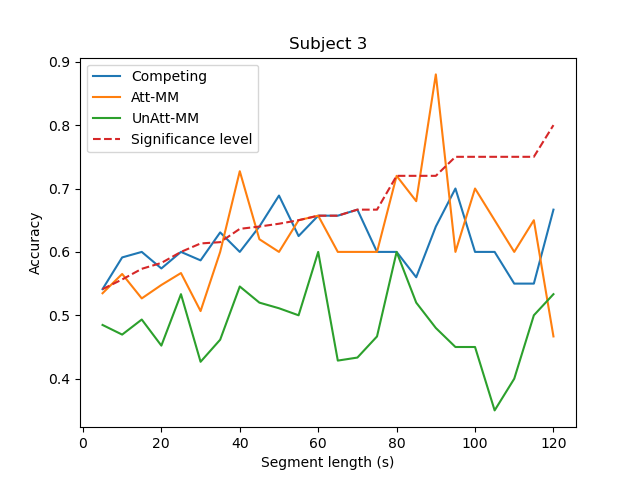

In [34]:
plt.close()

# Plot lines
plt.plot(trial_len_list, acc_list, label='Competing')
plt.plot(trial_len_list, acc_list_unatt_permu, label='Att-MM')
plt.plot(trial_len_list, acc_list_permu_att, label='UnAtt-MM')
plt.plot(trial_len_list, acc_sig_list, label='Significance level', linestyle='--')

# Assuming p_values_list, p_values_list_unatt_permu, and p_values_list_permu_att are the lists of p-values for each condition
# Plot circles where p-value < 0.05
# for trial_len, acc, p_value in zip(trial_len_list, acc_list, p_values_list):
#     if p_value > 0.05:
#         plt.scatter(trial_len, acc, edgecolors='red', facecolors='none', s=100)

# for trial_len, acc, p_value in zip(trial_len_list, acc_list_unatt_permu, p_values_list_unatt_permu):
#     if p_value > 0.05:
#         plt.scatter(trial_len, acc, edgecolors='red', facecolors='none', s=100)

# for trial_len, acc, p_value in zip(trial_len_list, acc_list_permu_att, p_values_list_att_permu):
#     if p_value > 0.05:
#         plt.scatter(trial_len, acc, edgecolors='red', facecolors='none', s=100)

plt.legend()
plt.xlabel('Segment length (s)')
plt.ylabel('Accuracy')
plt.title('Subject ' + str(Subj_ID+1))
plt.show()

## Using EOG signals or eye tracking data

In [35]:
Subj_ID = 2 # starts from 0
feat_list = objflow_att_list
figure_name = figure_path + str(Subj_ID+1) + 'DOESNOTMATTER.png'
table_name = table_path + str(Subj_ID+1) + 'DOESNOTMATTER.pkl'
pipe_CCA_mm(Subj_ID, eog_multisubj_list, feat_list, fsStim, L_EEG, L_Stim, offset_EEG, offset_Stim, figure_name, table_name, trials=True, trial_len_list=None, ifEOG=True)

100%|██████████| 1000/1000 [00:03<00:00, 296.19it/s]

Significance level: 0.01732988995282227
Average correlation coefficients of the top 5 components on the training sets: [0.0393009  0.02975668 0.02243822 0.02061132 0.01579807]
Average correlation coefficients of the top 5 components on the test sets: [0.02267756 0.0058886  0.00441274 0.00081174 0.00453805]


In [59]:
Subj_ID = 2 # starts from 0
feat_list = objflow_att_list
figure_name = figure_path + str(Subj_ID+1) + 'DOESNOTMATTER.png'
table_name = table_path + str(Subj_ID+1) + 'DOESNOTMATTER.pkl'
pipe_CCA_mm(Subj_ID, gaze_multisubj_list, feat_list, fsStim, L_EEG, L_Stim, offset_EEG, offset_Stim, figure_name, table_name, trials=True, trial_len_list=None, ifEOG=True)

100%|██████████| 1000/1000 [00:06<00:00, 157.91it/s]

Significance level: 0.017659957633696842
Average correlation coefficients of the top 5 components on the training sets: [0.05941148 0.02101691 0.01642681 0.01177039 0.00978414]
Average correlation coefficients of the top 5 components on the test sets: [ 0.05440875  0.05174174 -0.00603396  0.00285103 -0.00926278]


In [60]:
Subj_ID = 2
trial_len = 60
feat_att_list = objflow_att_list
feat_unatt_list = objflow_unatt_list
corr_att_fold, corr_unatt_fold, V_eeg_train, sig_corr_att, sig_corr_unatt = att_or_unatt(Subj_ID, gaze_multisubj_list, feat_att_list, feat_unatt_list, fsStim, L_EEG, L_Stim, offset_EEG, offset_Stim, TRAIN_WITH_ATT=True, trial_len=trial_len)
print("Mode 1: train and test with attended features")
if trial_len is not None:
    print(np.average(np.average(corr_att_fold, axis=0), axis=0), sig_corr_att)
else:
    print(np.average(corr_att_fold, axis=0), sig_corr_att)
print("Mode 2: train with attended features and test with unattended features")
if trial_len is not None:
    print(np.average(np.average(corr_unatt_fold, axis=0), axis=0), sig_corr_unatt)
else:
    print(np.average(corr_unatt_fold, axis=0), sig_corr_unatt)
corr_att_fold, corr_unatt_fold, V_eeg_train, sig_corr_att, sig_corr_unatt = att_or_unatt(Subj_ID, gaze_multisubj_list, feat_att_list, feat_unatt_list, fsStim, L_EEG, L_Stim, offset_EEG, offset_Stim, TRAIN_WITH_ATT=False, trial_len=trial_len)
print("Mode 3: train and test with unattended features")
if trial_len is not None:
    print(np.average(np.average(corr_unatt_fold, axis=0), axis=0), sig_corr_unatt)
else:
    print(np.average(corr_unatt_fold, axis=0), sig_corr_unatt)

100%|██████████| 1000/1000 [00:06<00:00, 148.40it/s]


Mode 1: train and test with attended features
[ 0.05440875  0.05174174 -0.00603396  0.00285103 -0.00926278] 0.01778906444029332
Mode 2: train with attended features and test with unattended features
[ 0.00433909  0.06721115 -0.0047337   0.00751883 -0.0036023 ] 0.017567056020867108


100%|██████████| 1000/1000 [00:06<00:00, 159.80it/s]

Mode 3: train and test with unattended features
[-0.06591301  0.00448664  0.0088239  -0.01086975  0.01163789] 0.01798185254748316


In [36]:
PermuAtt = False
PermuUnatt = False
table_name = table_path + str(Subj_ID+1) + '_compete_eog.pkl'
pipe_acc_trials(Subj_ID, eog_multisubj_list, feat_att_list, feat_unatt_list, fsStim, L_EEG, L_Stim, offset_EEG, offset_Stim, trial_len_list, table_name, PermuUnatt, PermuAtt)

Trial length:  5
Mean corr with attended features across trials and folds:  [0.01632275 0.00012784]
Mean corr with unattended features across trials and folds:  [-0.00189114 -0.00447956]
Accuracy:  0.5434782608695652  p-value:  0.03444462370387987
Trial length:  10
Mean corr with attended features across trials and folds:  [0.01665549 0.00589438]
Mean corr with unattended features across trials and folds:  [-0.00343295  0.00012381]
Accuracy:  0.5391304347826087  p-value:  0.13113351455209474
Trial length:  15
Mean corr with attended features across trials and folds:  [0.0160389  0.00779368]
Mean corr with unattended features across trials and folds:  [-0.00019393 -0.00160876]
Accuracy:  0.54  p-value:  0.18458073483089402
Trial length:  20
Mean corr with attended features across trials and folds:  [0.01728774 0.00829922]
Mean corr with unattended features across trials and folds:  [-0.00281756 -0.00297932]
Accuracy:  0.5826086956521739  p-value:  0.046407960491094837
Trial length:  25


In [66]:
PermuAtt = False
PermuUnatt = False
table_name = table_path + str(Subj_ID+1) + '_compete_eyetracker.pkl'
pipe_acc_trials(Subj_ID, gaze_multisubj_list, feat_att_list, feat_unatt_list, fsStim, L_EEG, L_Stim, offset_EEG, offset_Stim, trial_len_list, table_name, PermuUnatt, PermuAtt)

Trial length:  5
Mean corr with attended features across trials and folds:  [-0.03693355  0.27312865]
Mean corr with unattended features across trials and folds:  [-0.02991284  0.28308761]
Accuracy:  0.4673913043478261  p-value:  0.9258647488711581
Trial length:  10
Mean corr with attended features across trials and folds:  [-0.02312267  0.20339035]
Mean corr with unattended features across trials and folds:  [-0.00847303  0.21523948]
Accuracy:  0.45652173913043476  p-value:  0.9169979240172238
Trial length:  15
Mean corr with attended features across trials and folds:  [-0.01174123  0.15597507]
Mean corr with unattended features across trials and folds:  [-0.01630439  0.17047385]
Accuracy:  0.42  p-value:  0.979565753066753
Trial length:  20
Mean corr with attended features across trials and folds:  [-0.00415402  0.12704448]
Mean corr with unattended features across trials and folds:  [-0.00710644  0.14358162]
Accuracy:  0.4434782608695652  p-value:  0.9042520324398592
Trial length:  

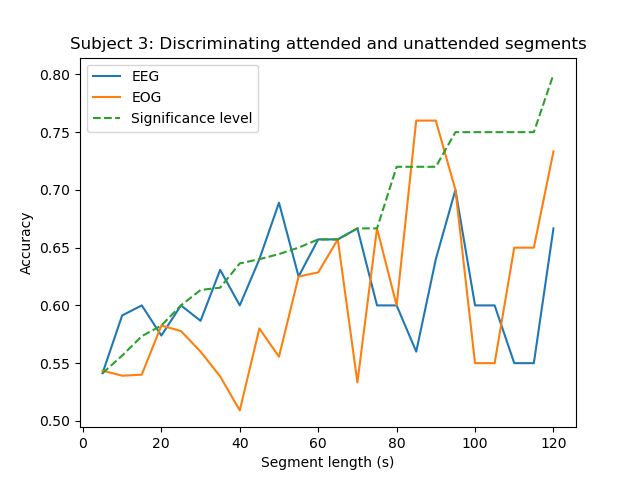

In [38]:
with open(table_path + str(Subj_ID+1) + '_compete_eog.pkl', 'rb') as f: 
    results = pickle.load(f)
    acc_list_eog = results['acc']
    p_values_list_eog = results['pvalue']
# with open(table_path + str(Subj_ID+1) + '_compete_eyetracker.pkl', 'rb') as f:
#     results = pickle.load(f)
#     acc_list_eyetracker = results['acc']
#     p_values_list_eyetracker = results['pvalue']
with open(table_path + str(Subj_ID+1) + '_compete.pkl', 'rb') as f:
    results = pickle.load(f)
    acc_list = results['acc']
    p_values_list = results['pvalue']
    acc_sig_list = results['acc_sig']
    trial_len_list = results['trial_len_list']
plt.close()
plt.plot(trial_len_list, acc_list, label='EEG')
plt.plot(trial_len_list, acc_list_eog, label='EOG')
# plt.plot(trial_len_list, acc_list_eyetracker, label='Eye tracker')
plt.plot(trial_len_list, acc_sig_list, label='Significance level', linestyle='--')

# for trial_len, acc, p_value in zip(trial_len_list, acc_list, p_values_list):
#     if p_value > 0.05:
#         plt.scatter(trial_len, acc, edgecolors='red', facecolors='none', s=100)

# for trial_len, acc, p_value in zip(trial_len_list, acc_list_eog, p_values_list_eog):
#     if p_value > 0.05:
#         plt.scatter(trial_len, acc, edgecolors='red', facecolors='none', s=100)

# for trial_len, acc, p_value in zip(trial_len_list, acc_list_eyetracker, p_values_list_eyetracker):
#     if p_value > 0.05:
#         plt.scatter(trial_len, acc, edgecolors='red', facecolors='none', s=100)

plt.legend()
plt.xlabel('Segment length (s)')
plt.ylabel('Accuracy')
plt.title('Subject ' + str(Subj_ID+1) + ': Discriminating attended and unattended segments')
plt.show()

## Correlations between EEG signals when looking at the same video pairs but attending different objects

In [ ]:
L_eeg = 3
offset_eeg = 1
eeg_set1_onesubj_list = [eeg[:,:,Subj_ID] for eeg in eeg_set1_list]
eeg_set2_onesubj_list = [eeg[:,:,Subj_ID] for eeg in eeg_set2_list]
CCA = algo.CanonicalCorrelationAnalysis(eeg_set1_onesubj_list, eeg_set2_onesubj_list, fsStim, L_eeg, L_eeg, offset_eeg, offset_eeg, fold=5, signifi_level=True, n_components=5)
_, corr_test, sig_corr, _, tsc_test, _, _, V_A_train, V_B_train = CCA.cross_val()

In [ ]:
# Concatenate the EEG signals of different subjects together (along the time axis)
def concat_multi_subj_eeg(eeg_multisubj):
    _, _, nb_subj = eeg_multisubj.shape
    eeg_subj_list = [eeg_multisubj[:,:,i] for i in range(nb_subj)]
    eeg_concat = np.concatenate(tuple(eeg_subj_list), axis=0)
    return eeg_concat

In [ ]:
eeg_set1_array_list = [concat_multi_subj_eeg(eeg) for eeg in eeg_set1_list]
eeg_set2_array_list = [concat_multi_subj_eeg(eeg) for eeg in eeg_set2_list]

In [ ]:
CCA = algo.CanonicalCorrelationAnalysis(eeg_set1_array_list, eeg_set2_array_list, fsStim, L_eeg, L_eeg, offset_eeg, offset_eeg, fold=5, signifi_level=True, n_components=5)
_, corr_test, sig_corr, _, tsc_test, _, _, V_A_train, V_B_train = CCA.cross_val()

In [ ]:
eeg_set1_set2_tensor_list = [np.concatenate((eeg_set1, eeg_set2), axis=2) for eeg_set1, eeg_set2 in zip(eeg_set1_list, eeg_set2_list)]

In [ ]:
GCCA = algo.GeneralizedCCA(eeg_set1_set2_tensor_list, fs, L=5, offset=2, n_components=10, signifi_level=True, trials=True)
corr_train, corr_test, cov_train, cov_test, tsc_train, tsc_test, dist_train, dist_test, W_train, F_train_GCCA = GCCA.cross_val()

In [ ]:
utils.plot_spatial_resp(F_train_GCCA, corr_test, 'set1_set2.pdf', ifISC=True)